## Imports

In [10]:
import sys
import os
sys.path.append(os.path.expanduser("~/Desktop/Kaitlyn_Catalyst/ct_classifier/speciesnet"))
from speciesnet.classifier import SpeciesNetClassifier
from speciesnet.detector import SpeciesNetDetector
from speciesnet.constants import Detection
from speciesnet.ensemble_prediction_combiner import combine_predictions_for_single_item
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

In [2]:
import inspect
from speciesnet.classifier import SpeciesNetClassifier
print(inspect.getfile(SpeciesNetClassifier))

/home/sabdelazim/miniconda3/envs/cv4ecology/lib/python3.11/site-packages/speciesnet/classifier.py


## Download models

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.model_download("google/speciesnet/pyTorch/v4.0.1a")

# print("Path to model files:", path)

## Initializing

In [3]:
# === Paths ===
image_path = os.path.join(
    os.environ["HOME"],
    "Desktop",
    "Kaitlyn_Catalyst",
    "ct_classifier",
    "datasets",
    "all_species_images",
    "493_g08_mongoose_bushy_tailed.jpg"
)
img = Image.open(image_path).convert("RGB")

# === Device Setup ===
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.model_download("google/speciesnet/pyTorch/v4.0.1a")

# print("Path to model files:", path)

In [ ]:
import inspect
from speciesnet.classifier import SpeciesNetClassifier
print(inspect.getfile(SpeciesNetClassifier))

## Detection

Detections:
Category: 1, Label: animal, Confidence: 0.98, BBox: [0.0, 0.5976562798023224, 0.40771484375, 0.2604166865348816]
Normalized bbox: [0.0, 0.5976562798023224, 0.40771484375, 0.2604166865348816]
Absolute bbox: x_min=0, y_min=918, x_max=835, y_max=1318


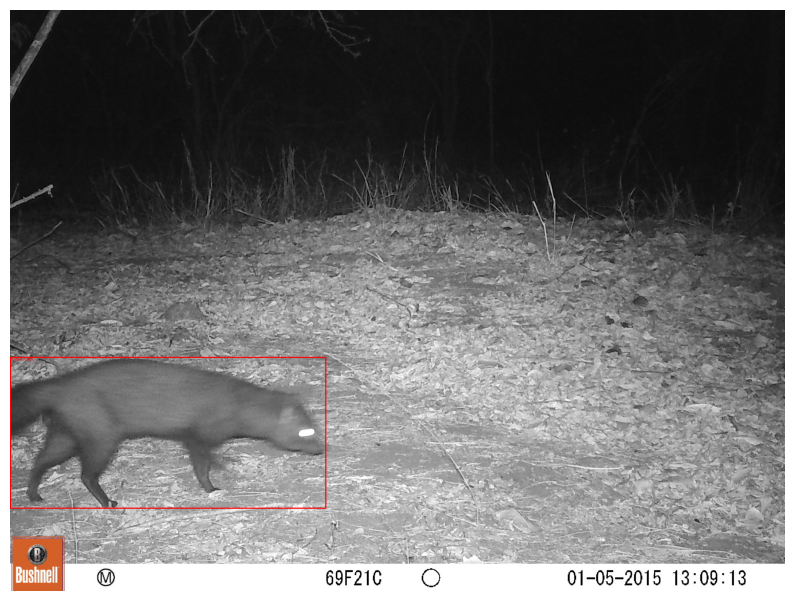

In [4]:
detector_model_name = "/Users/sarahabdelazim/.cache/kagglehub/models/google/speciesnet/pyTorch/v4.0.1a/1"

model_name = os.path.join(os.environ["HOME"], ".cache", "kagglehub", "models", "google", "speciesnet", "pyTorch", "v4.0.1a", "1")


# === Create an Instance of Detector ===
detector = SpeciesNetDetector(model_name)
preprocessed_image = detector.preprocess(img)

# === Run Detection ===
detections_result = detector.predict(filepath=image_path, img=preprocessed_image)

# === Display Detection Results ===
print("Detections:")
for detection in detections_result.get("detections", []):
    print(
        f"Category: {detection['category']}, "
        f"Label: {detection['label']}, "
        f"Confidence: {detection['conf']:.2f}, "
        f"BBox: {detection['bbox']}"
    )

# === Handle Failures ===
if "failures" in detections_result:
    print("Detection failed for the following reasons:", detections_result["failures"])

draw = ImageDraw.Draw(img)

# Iterate over detections
for detection in detections_result.get("detections", []):
    bbox = detection['bbox']  # [x_min, y_min, width, height]
    
    # Convert normalized bbox (relative coordinates) to absolute pixel values
    x_min = int(bbox[0] * img.width)
    y_min = int(bbox[1] * img.height)
    # Correctly calculate x_max and y_max
    x_max = int((bbox[0] + bbox[2]) * img.width)
    y_max = int((bbox[1] + bbox[3]) * img.height)

    # Debugging: Print bounding box values
    print(f"Normalized bbox: {bbox}")
    print(f"Absolute bbox: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")

    # Skip invalid bounding boxes
    if x_max < x_min or y_max < y_min:
        print(f"Skipping invalid bbox: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")
        continue

    # Draw rectangle (bounding box)
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

    # Optional: Add label and confidence score
    label = f"{detection['label']} ({detection['conf']:.2f})"
    draw.text((x_min, y_min), label, fill="red")

# === Display Image with Bounding Boxes in Jupyter ===
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Turn off axes for better visualization
plt.show()

In [5]:
detections_result

{'filepath': '/home/sabdelazim/Desktop/Kaitlyn_Catalyst/ct_classifier/datasets/all_species_images/493_g08_mongoose_bushy_tailed.jpg',
 'detections': [{'category': '1',
   'label': 'animal',
   'conf': 0.9806643724441528,
   'bbox': [0.0, 0.5976562798023224, 0.40771484375, 0.2604166865348816]}]}

## Classification (speciesnet)

In [ ]:
# for name, layer in model.model.named_children():
#     print(f"{name}: {layer}")
# for name, layer in model.model.named_modules():
#     print(f"{name}: {layer}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AugmentedSpeciesNet(nn.Module):
    def __init__(self, base_model, original_outputs, target_labels, use_extra_head=True, dropout=0.5):
        super().__init__()
        self.base_model = base_model
        self.use_extra_head = use_extra_head

        if self.use_extra_head:
            hidden_dim = original_outputs // 2

            self.intermediate_head = nn.Linear(original_outputs, hidden_dim)
            self.dropout = nn.Dropout(p=dropout)  # <-- Added dropout
            self.final_head = nn.Linear(hidden_dim, target_labels)

            # === Freeze entire base model ===
            for param in self.base_model.parameters():
                param.requires_grad = False

            # === Unfreeze last two trainable layers: top_conv and dense ===
            for name, module in self.base_model.named_modules():
                if "top_conv" in name or "dense" in name:
                    for param in module.parameters():
                        param.requires_grad = True
                    print(f"Unfroze layer: {name}")

            # Initialize extra heads
            nn.init.xavier_uniform_(self.intermediate_head.weight)
            nn.init.zeros_(self.intermediate_head.bias)
            nn.init.xavier_uniform_(self.final_head.weight)
            nn.init.zeros_(self.final_head.bias)
        else:
            # Unfreeze all layers in base model if using directly
            for param in self.base_model.parameters():
                param.requires_grad = True

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()  # [B, C, H, W] → [B, H, W, C]
        base_logits = self.base_model(x.to(x.device))  # [B, original_outputs]

        if self.use_extra_head:
            x = self.intermediate_head(base_logits)
            x = torch.relu(x)
            x = self.dropout(x)  # <-- Apply dropout here
            return self.final_head(x)
        else:
            return base_logits

In [ ]:
from speciesnet.classifier import SpeciesNetClassifier
from PIL import Image
from speciesnet.utils import BBox 

classifier_model_name = os.path.expanduser("~/.cache/kagglehub/models/google/speciesnet/pyTorch/v4.0.1a/1")

# === Configuration ===
target_species_txt = os.path.join(
    os.environ["HOME"],
    "Desktop",
    "Kaitlyn_Catalyst",
    "ct_classifier",
    "target_species_top4.txt")

# Load the classifier
# === Load classifier and wrap model ===
classifier = SpeciesNetClassifier(model_name=classifier_model_name, target_species_txt=target_species_txt)
original_outputs = len(classifier.labels)
target_labels = len(classifier.target_labels)

classifier.model = AugmentedSpeciesNet(
    classifier.model,
    original_outputs,
    target_labels,
    use_extra_head=True
)
classifier.model = classifier.model.to(device)

In [ ]:
# for name, module in classifier.model.named_modules():
#     if "dense" in name.lower() or "matmul" in name.lower() or "bias" in name.lower():
#         print(name, ":", type(module))

In [ ]:
# dense_layer = dict(classifier.model.named_modules())["SpeciesNet/dense/MatMul"]
# print(dense_layer)

In [ ]:
# outputs = {}

# def get_hook(name):
#     def hook_fn(module, input, output):
#         outputs[name] = output
#     return hook_fn

# # Register hooks
# for name, module in classifier.model.named_modules():
#     if "dense" in name.lower():
#         print("Hooking into layer:", name)
#         module.register_forward_hook(get_hook(name))

In [ ]:
# result = classifier.predict(filepath=image_path, img=preprocessed)
# for layer_name, output in outputs.items():
#     print(f"🔍 Output from {layer_name}: {output.shape}")

In [ ]:
# matmul_layer = dict(classifier.model.named_modules())["SpeciesNet/dense/MatMul"]
# print("Weights:", list(matmul_layer.parameters()))

In [ ]:
# for name, module in classifier.model.named_modules():
#     print(name, ":", type(module))

## Classification (custom resnet18)

In [20]:
import os, sys, importlib

# Add the *project root* so Python sees the inner package `ct_classifier`
root = os.path.expanduser("~/Desktop/Kaitlyn_Catalyst/ct_classifier")
if root not in sys.path:
    sys.path.insert(0, root)

# Clear any cached generic 'model' module from earlier imports
sys.modules.pop('model', None)

# Now import from the package explicitly
from ct_classifier.model import CustomResNet18
from torchvision import transforms
from PIL import Image
import torch
import os
import ast  # to parse bbox if it’s a string like "[x1, y1, x2, y2]"
from tqdm import tqdm
from speciesnet.utils import BBox
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import pandas as pd
import os
import re

import os
import gc
from tqdm import tqdm
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
sys.path.append(os.path.expanduser("~/Desktop/Kaitlyn_Catalyst/ct_classifier/speciesnet"))
from speciesnet.detector import SpeciesNetDetector
from splitting import stratified_site_split_from_folder, filter_df_with_detections
from dataloader import SpeciesImageDataset   # <- updated to allow classifier=None + transform
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader
from torchvision.models import ResNet18_Weights
import wandb

In [23]:
import torch
from torch.utils.data import DataLoader

# Assume train_dataset is already created from SpeciesImageDataset
# and model is an instance of CustomResNet18

# Put model in eval mode
model.eval()

# Get one batch from your DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
images, labels = next(iter(train_loader))

# Move to device
images = images.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(images)  # shape: [batch_size, num_classes]

print("Model output tensor shape:", outputs.shape)   # e.g. (4, 4) for top4_only
print("Model output tensor values:\n", outputs)

# If you want predicted class indices:
preds = torch.argmax(outputs, dim=1)
print("Predicted class indices:", preds.cpu().numpy())

# If you want probabilities:
probs = torch.softmax(outputs, dim=1)
print("Class probabilities:\n", probs)

Model output tensor shape: torch.Size([4, 4])
Model output tensor values:
 tensor([[-0.64327, -0.02481,  1.44538,  0.29635],
        [-1.78553,  1.91235,  0.48007,  0.67355],
        [-0.83903,  0.69441,  0.28303,  0.13983],
        [-1.14155,  0.20432,  0.95674,  0.21079]], device='mps:0')
Predicted class indices: [2 1 1 2]
Class probabilities:
 tensor([[0.07413, 0.13760, 0.59856, 0.18971],
        [0.01595, 0.64380, 0.15372, 0.18653],
        [0.08798, 0.40769, 0.27019, 0.23414],
        [0.05931, 0.22785, 0.48352, 0.22933]], device='mps:0')


In [29]:
# === Device Selection ===
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

# === Config ===
base_dir = os.path.expanduser("~/Desktop/Kaitlyn_Catalyst/ct_classifier")
csv_path = os.path.join(base_dir, "notebooks", "full_df_filtered.csv")
target_species_txt = os.path.join(base_dir, "target_species_top4.txt")
image_dir = os.path.join(base_dir, "datasets", "all_species_images")
classifier_model_name = os.path.expanduser("~/.cache/kagglehub/models/google/speciesnet/pyTorch/v4.0.1a/1")
num_epochs = 15
batch_size = 16

# === Initialize Weights & Biases ===
wandb.init(
    project="Species-Classification",
    config={
        "epochs": 15,
        "lr": 1e-4,
        "batch_size": 16,
        "model": "SpeciesNet-Top4",
        "label_smoothing": 0.1,
        "weight_decay": 5e-4,
        "dropout": 0.5
    }
)

wandb.define_metric("epoch")
wandb.define_metric("*", step_metric="epoch")

config = wandb.config

# Dynamically rename run based on sweep config
wandb.run.name = f"ls_{config.label_smoothing}-wd_{config.weight_decay}-do_{config.dropout}"

print(f"Using '{device}' device", flush=True)

# === Load Data ===
full_df = pd.read_csv(csv_path)
train_df, val_df = stratified_site_split_from_folder(image_dir, test_size=0.3)

# === Detector ===
detector = SpeciesNetDetector(model_name=classifier_model_name)

# === Filter by detector and cache ===
train_filtered_path = os.path.join(base_dir, "speciesnet/train_filtered.csv")
val_filtered_path = os.path.join(base_dir, "speciesnet/val_filtered.csv")

if os.path.exists(train_filtered_path) and os.path.exists(val_filtered_path):
    print("Using cached filtered CSVs.")
    train_filtered_df = pd.read_csv(train_filtered_path)
    val_filtered_df = pd.read_csv(val_filtered_path)
else:
    print("Running detector to filter train/val...")
    train_filtered_df = filter_df_with_detections(train_df, image_dir, detector)
    val_filtered_df = filter_df_with_detections(val_df, image_dir, detector)
    train_filtered_df.to_csv(train_filtered_path, index=False)
    val_filtered_df.to_csv(val_filtered_path, index=False)
    print("Filtered train/val saved.")

# === Load classifier and wrap model ===
model = CustomResNet18(num_classes=4).to(device)

# Use sweep values
label_smoothing = config.label_smoothing
weight_decay = config.weight_decay
dropout = config.dropout

# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=weight_decay)

# === DataLoaders ===
train_dataset = SpeciesImageDataset(train_filtered_df, image_dir, model, top4_only=True)
val_dataset = SpeciesImageDataset(val_filtered_df, image_dir, model, top4_only=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# === Training Loop ===
best_train_acc = 0.0
best_train_epoch = 0
best_train_preds = []
best_train_trues = []

best_val_acc = 0.0
best_val_epoch = 0
best_val_preds = []
best_val_trues = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    train_loss = 0.0
    train_preds, train_trues = [], []

    for x_batch, y_batch in tqdm(train_loader, desc="Training"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.detach().cpu().numpy())
        train_trues.extend(y_batch.detach().cpu().numpy())

        del x_batch, y_batch, outputs, preds

    avg_train_loss = train_loss / len(train_loader)
    train_acc = accuracy_score(train_trues, train_preds)

    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_train_epoch = epoch + 1
        best_train_preds = train_preds.copy()
        best_train_trues = train_trues.copy()

    model.eval()
    val_loss = 0.0
    val_preds, val_trues = [], []

    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_loader, desc="Validating"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.detach().cpu().numpy())
            val_trues.extend(y_batch.detach().cpu().numpy())

            del x_batch, y_batch, outputs, preds

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_trues, val_preds)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_epoch = epoch + 1
        best_val_preds = val_preds.copy()
        best_val_trues = val_trues.copy()

    with open("id_to_species_full.json", "r") as f:
        id_to_species = json.load(f)

    targetlabel_to_shortname = {
        info["target_label"]: info["short_name"].replace(" ", "_")
        for info in id_to_species.values()
    }
    shortnames = [targetlabel_to_shortname[label] for label in classifier.target_labels]

    # === Always compute and log classification reports ===
    train_report = classification_report(
        train_trues,
        train_preds,
        target_names=shortnames,
        labels=list(range(len(shortnames))),
        output_dict=True)

    val_report = classification_report(
        val_trues,
        val_preds,
        target_names=shortnames,
        labels=list(range(len(shortnames))),
        output_dict=True)

    wandb.log({
        "epoch": epoch + 1,
        "train/avg_loss": avg_train_loss,
        "train/accuracy": train_acc,
        "val/avg_loss": avg_val_loss,
        "val/accuracy": val_acc,
    })

    for short_name in shortnames:
        if short_name in train_report:
            wandb.log({
                f"{short_name}/train_precision": train_report[short_name]["precision"],
                f"{short_name}/train_recall": train_report[short_name]["recall"],
                f"{short_name}/train_f1": train_report[short_name]["f1-score"],
            }, step=epoch + 1)

        if short_name in val_report:
            wandb.log({
                f"{short_name}/val_precision": val_report[short_name]["precision"],
                f"{short_name}/val_recall": val_report[short_name]["recall"],
                f"{short_name}/val_f1": val_report[short_name]["f1-score"],
            }, step=epoch + 1)

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"Best Train Epoch: {best_train_epoch} | Acc: {best_train_acc:.4f}")
    print(f"Best Val Epoch: {best_val_epoch} | Acc: {best_val_acc:.4f}")

# === Final confusion matrix logging ===
wandb.log({
    "best_train/confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=best_train_trues,
        preds=best_train_preds,
        class_names=shortnames
    ),
    "best_val/confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=best_val_trues,
        preds=best_val_preds,
        class_names=shortnames
    )
})

wandb.finish()

Using 'mps' device


/var/folders/dc/_grr_lq141g3_rxfxtd017rm0000gn/T/ipykernel_31832/651640041.py:42: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(csv_path)


Using cached filtered CSVs.
Epoch 1/15


Training:   1%|▎                                | 24/2557 [00:10<18:59,  2.22it/s]


KeyboardInterrupt: 

## Get Layer Names

In [ ]:
# Retrieve and print the layer names
# layer_names = [name for name, _ in classifier.model.named_modules()]
# print("Layer Names:")
# for name in layer_names:
#     print(name)

In [ ]:
import sys
import os
sys.path.append(os.path.expanduser("~/Desktop/Kaitlyn_Catalyst/ct_classifier/speciesnet"))
from dataloader import SpeciesImageDataset
from speciesnet.classifier import SpeciesNetClassifier
# from model import AugmentedSpeciesNet
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.optim as optim
import torch
import numpy as np
from torch.nn.utils import clip_grad_norm_


device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda:1") if torch.cuda.is_available()
    else torch.device("cpu")
)

In [ ]:
base_dir = os.path.expanduser("~/Desktop/Kaitlyn_Catalyst/ct_classifier")
csv_path = os.path.join(base_dir, "notebooks", "full_df_filtered.csv")
target_species_txt = os.path.join(base_dir, "target_species_top4.txt")
image_dir = os.path.join(base_dir, "datasets", "all_species_images")
train_filtered_path = os.path.join(base_dir, "speciesnet/train_filtered.csv")
val_filtered_path = os.path.join(base_dir, "speciesnet/val_filtered.csv")
train_filtered_df = pd.read_csv(train_filtered_path)
val_filtered_df = pd.read_csv(val_filtered_path)
classifier_model_name = os.path.expanduser("~/.cache/kagglehub/models/google/speciesnet/pyTorch/v4.0.1a/1")


# === DataLoaders ===
train_dataset = SpeciesImageDataset(train_filtered_df, image_dir, classifier)
val_dataset = SpeciesImageDataset(val_filtered_df, image_dir, classifier)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

In [ ]:
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

In [ ]:
# === Load classifier and wrap model ===
classifier = SpeciesNetClassifier(model_name=classifier_model_name, target_species_txt=target_species_txt)
original_outputs = len(classifier.labels)
target_labels = len(classifier.target_labels)

classifier.model = AugmentedSpeciesNet(
    classifier.model,
    original_outputs,
    target_labels,
    use_extra_head=False,
    dropout=0.5
)
classifier.model = classifier.model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(classifier.model.parameters(), lr=1e-4, weight_decay=1e-5)

for x_batch, y_batch in tqdm(train_loader, desc="Training"):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    outputs = classifier.model(x_batch)

    # Debug prints
    print("Outputs shape:", outputs.shape)
    print("Sample outputs (first 1-2 rows):", outputs[:2].detach().cpu())
    print("Logits min/max:", outputs.min().item(), outputs.max().item())

    loss = criterion(outputs, y_batch)
    print("Loss:", loss.item())

    # === Backpropagation ===
    loss.backward()

    torch.nn.utils.clip_grad_norm_(classifier.model.parameters(), max_norm=1.0)

    # === Update weights ===
    optimizer.step()

    break 

In [ ]:
print(target_labels)

In [ ]:
# === Load Classifier ===
classifier = SpeciesNetClassifier(model_name=classifier_model_name, target_species_txt=target_species_txt)
classifier.model.eval()
classifier.model.to(device)

# === Build mapping for selecting correct logits ===
value_to_index = {v: k for k, v in classifier.labels.items()}
target_indices = [value_to_index[label] for label in classifier.target_labels]
len(target_indices)

In [ ]:
# for name, param in classifier.model.named_parameters():
#     print(f"Name: {name}, Shape: {param.shape}, Requires Grad: {param.requires_grad}")

## Add Inference

In [ ]:
import os
import json
import torch
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from speciesnet.classifier import SpeciesNetClassifier
from dataloader import SpeciesImageDataset

# === Config & Paths ===
base_dir = os.path.expanduser("~/Desktop/Kaitlyn_Catalyst/ct_classifier")
csv_train = os.path.join(base_dir, "speciesnet/train_filtered.csv")
csv_val = os.path.join(base_dir, "speciesnet/val_filtered.csv")
image_dir = os.path.join(base_dir, "datasets", "all_species_images")
target_species_txt = os.path.join(base_dir, "target_species.txt")
classifier_model_name = os.path.expanduser("~/.cache/kagglehub/models/google/speciesnet/pyTorch/v4.0.1a/1")

# === Device ===
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

# === Load model ===
classifier = SpeciesNetClassifier(
    model_name=classifier_model_name,
    target_species_txt=target_species_txt
)
classifier.model.eval()
classifier.model.to(device)

# === Load combined dataset ===
df_train = pd.read_csv(csv_train)
df_val = pd.read_csv(csv_val)
combined_df = pd.concat([df_train, df_val], ignore_index=True)

# === Build reverse mapping: taxonomy string → model output index
value_to_index = {v: k for k, v in classifier.labels.items()}
target_indices = [value_to_index[label] for label in classifier.target_labels]

# === Inference function
def run_inference_on_sample(sample_df_row):
    dataset = SpeciesImageDataset(pd.DataFrame([sample_df_row]), image_dir, classifier)
    x, y = dataset[0]
    x = x.unsqueeze(0).to(device)
    y = torch.tensor([y]).to(device)

    logits_full = classifier.model(x.permute(0, 2, 3, 1).contiguous())
    print(logits_full.shape)
    logits = logits_full[:, target_indices]
    print(logits.shape)

    pred_idx = torch.argmax(logits, dim=1).item()
    pred_species = classifier.target_labels[pred_idx]
    true_species = classifier.target_labels[y.item()]

    img_path = os.path.join(image_dir, sample_df_row["filename"])
    img = Image.open(img_path).convert("RGB")

    plt.imshow(img)
    plt.title(f"True: {true_species.split(';')[-1]}\nPred: {pred_species.split(';')[-1]}")
    plt.axis("off")
    plt.show()

    print("Filename:", sample_df_row["filename"])
    print("✅ True species:", true_species)
    print("🔮 Predicted species:", pred_species)

# === Run on N random samples
N = 5  # or any number you like
for i in range(N):
    print(f"\n🔁 Sample {i+1}/{N}")
    run_inference_on_sample(combined_df.sample(n=1).iloc[0])

## Add Ground_Truth_Index to Train and Val

In [ ]:
# import json
# import pandas as pd

# train_filtered = pd.read_csv("/home/sabdelazim/Desktop/Kaitlyn_Catalyst/ct_classifier/speciesnet/train_filtered.csv")
# val_filtered = pd.read_csv("/home/sabdelazim/Desktop/Kaitlyn_Catalyst/ct_classifier/speciesnet/val_filtered.csv")

# # === Step 1: Load the JSON
# json_path = "/home/sabdelazim/Desktop/Kaitlyn_Catalyst/ct_classifier/speciesnet/id_to_species_full.json"
# with open(json_path, "r") as f:
#     id_to_species_dict = json.load(f)

# # Convert dict-of-entries to a list based on key order
# id_to_species = [id_to_species_dict[str(i)] for i in range(len(id_to_species_dict))]

# # === Step 2: Build short_name → index mapping
# shortname_to_index = {
#     entry["short_name"]: idx
#     for idx, entry in enumerate(id_to_species)
# }

# # === Step 3: Apply mapping to DataFrames
# for df in [train_filtered, val_filtered]:
#     df["ground_truth_index"] = df["species"].map(shortname_to_index)

In [ ]:
# train_filtered.to_csv("/home/sabdelazim/Desktop/Kaitlyn_Catalyst/ct_classifier/speciesnet/train_filtered.csv")
# val_filtered.to_csv("/home/sabdelazim/Desktop/Kaitlyn_Catalyst/ct_classifier/speciesnet/val_filtered.csv")

In [ ]:
base_dir = os.path.expanduser("~/Desktop/Kaitlyn_Catalyst/ct_classifier")
target_species_txt = os.path.join(base_dir, "target_species_top4.txt")
classifier_model_name = os.path.expanduser("~/.cache/kagglehub/models/google/speciesnet/pyTorch/v4.0.1a/1")
classifier = SpeciesNetClassifier(model_name=classifier_model_name, target_species_txt=target_species_txt)
original_outputs = len(classifier.labels)
target_labels = len(classifier.target_labels)

In [ ]:
print(original_outputs)

In [ ]:
# === Load classifier and wrap model ===

# Set to None to prevent TensorFlow from trying to load a non-TF model
# This works on both Mac and Unix assuming you'll override the model below
classifier = SpeciesNetClassifier(model_name=None, target_species_txt=target_species_txt)

original_outputs = len(classifier.labels)
target_labels = len(classifier.target_labels)

# Use sweep values
label_smoothing = config.label_smoothing
weight_decay = config.weight_decay
dropout = config.dropout

# Replace the model with your PyTorch-based model
classifier.model = AugmentedSpeciesNet(
    base_model=classifier.model,  # might be None or dummy — that's okay
    original_outputs=original_outputs,
    target_outputs=target_labels,
    use_extra_head=True,
    dropout=dropout
)
classifier.model = classifier.model.to(device)